In [2]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import coordinates as coord
import astropy.constants as const
import astropy.units as unit
import healpy as hp
from datetime import datetime
from functools import partial 
import sys, platform, os

In [3]:
# set plottign defaults
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

## Raytracing algorithm
This version uses a simple summation of the convergence field defined as 
the convergence is simply$$   \kappa(\vec \theta) = \frac {\Sigma(\vec \theta)} {\Sigma_{\rm cr}} $$

Then, eqn ££ can be written in terms of the surface mass as
$$ 
  \left \langle \gamma_{\rm t} \right\rangle (\theta) \, \Sigma_{\rm cr} = \Delta \Sigma(\le \theta) = \bar \Sigma(\theta) -
  \left \langle \Sigma \right \rangle (\theta) 
$$

$$
 \kappa (\vec{\theta}, \chi)= \frac{4 \pi G}{c^2}\frac{1}{\chi_{s}}\!\sum_{i} (1 + z^{(i)}) \frac{(\chi_{s}-\chi_{d}^{(i)})}{\chi_d^{(i)}}\left[\Sigma^{(i)}(\vec{\theta})\!-\!\bar{\Sigma}^{(i)}\right]
$$
where $\Sigma^{(i)}$ denotes the angular surface mass density, $\bar{\Sigma}^{(i)}$ is the mean angular surface mass density of the $i$-th shell, and $(\chi_{s} - \chi_{d}^{(i)})$ and $\chi_{d}^{(i)}$ are the corresponding distances at the redshift of the $i$-th shell. The angular position of the center of each \healpix{} pixel coincides with the direction of propagation of the rays in the Born approximation.

### Fosalba onion universe

$$ \kappa(\theta) = {3H_0^2\Omega_m\over{2c^2}}~\int ~dr~\delta(r,\theta){(r_s-r)r\over{r_s~a}} $$ 

where $\delta$ is the 3D matter density at radial distance $r$ and angular position $\theta$

Build our convergence map by just adding the onion slices from the simulation with the appropriate lensing weight. This can be done as
follows:

$$ \kappa(i) = {3H_0^2\Omega_m\over{2c^2}}~\sum_j ~\delta(i,j)~{(r_s-r_j)r_j\over{r_s a_j}}~dr_j$$ 

where $i$ indicates a pixel position in the sky and $j$ a radial bin
(at distance $r_j$ of width $dr_j$) into which we have sliced 
the simulation as described in the previous section. 
If we indicate by $N_{ij}$ the number of particles in pixel $i$ 
from onion slice $j$, we have:

$$ \delta(i,j)={\rho(i,j)\over{\bar{\rho}}}-1 $$
where $\bar{\rho}= <\rho(i,j)>$ and

$$ \rho(i,j) = {N_{ij}\over{dV_j}} = {N_{ij}\over{\Delta\Omega ~r_j^2~ dr_j}}$$
where $\Delta\Omega$ is the area of each pixel. 


In [4]:
def add_snapshot(snap):
    ngals = 0
    gals = []
    fname = 'galaxy_lightcone.snap{0:02d}'.format(snap)
    with h5py.File(fpath+fname,'r') as fi:
        for k in fi.keys():
            #print (k, fi[k].shape) 
            if True: # =='octant_0':
                g = fi[k]
                gals = g #[(g['Dec']<2) & (g['Dec']>-2)]
                L.extend(gals['L'])
                r.extend(gals['r'])
                ra.extend(gals['RA'])
                dec.extend(gals['Dec'])
                RSD.extend(gals['RSD'])
                zz.extend(gals['z'])
            else:
                g =np.empty(fi[k].shape, dtype=gal)
                fi[k].read_direct(g)       
                gals.extend(g)
            ngals += len(gals)
    return ngals

In [5]:
fpath = '/cosma6/data/dp004/dc-boot5/Lightcone/Galaxy_FullSky/'
# Initialise data arrays
L = []
zz = []
r = []
ra = []
dec = []
RSD = []

In [148]:
totgals = 0
galaxies  = []
for snap in range(56,64):
    ngals =add_snapshot(snap)
    totgals+=ngals
    #galaxies.extend(g)
    print("snapshot = ", snap,', total gals = ', ngals)
print("Grand total gals = ", totgals)

octant_0 (31758944,)
octant_1 (31290616,)
octant_2 (30829118,)
octant_3 (31748259,)
octant_4 (30763345,)
octant_5 (31198234,)
octant_6 (31615483,)
octant_7 (31823506,)
snapshot =  56 , total gals =  251027505
octant_0 (29086743,)
octant_1 (28946895,)
octant_2 (28158596,)
octant_3 (28967284,)
octant_4 (28473094,)
octant_5 (28829986,)
octant_6 (28614151,)
octant_7 (28944252,)
snapshot =  57 , total gals =  230021001
octant_0 (14131598,)
octant_1 (13725185,)
octant_2 (13562589,)
octant_3 (13727513,)
octant_4 (13999198,)
octant_5 (14051629,)
octant_6 (14161514,)
octant_7 (13445557,)
snapshot =  58 , total gals =  110804783
octant_0 (8416505,)
octant_1 (8314101,)
octant_2 (8930732,)
octant_3 (8379834,)
octant_4 (8420397,)
octant_5 (7931585,)
octant_6 (8291368,)
octant_7 (8411091,)
snapshot =  59 , total gals =  67095613
octant_0 (4461335,)
octant_1 (4731407,)
octant_2 (4860241,)
octant_3 (4462911,)
octant_4 (4782648,)
octant_5 (4508973,)
octant_6 (4515130,)
octant_7 (4337806,)
snapshot =  6

In [6]:
# read data from test file
outpath = '/cosma6/data/dp004/dc-boot5/Lightcone/Galaxy_FullSky_Reduced/'
fname = outpath + 'galaxy_lightcone_M_limited.h5'
with h5py.File(fname,'r') as fi:
    # open the galaxies dataset
    gals = fi['galaxies']

    # extract each data field into separate arrays
    zz = gals['z']
    r = gals['r']
    ra = gals['RA']
    dec = gals['Dec']
print('Finished reading {0:01d} galaxies'.format(len(r)))

Finished reading 120019177 galaxies


In [9]:
## set resolution
O_DE = 0.6914
o_b  = 0.022161
o_c = 0.11889
h = np.sqrt((o_b + o_c)/(1-O_DE))
O_m = (o_b + o_c)/(h*h)
nside = 8192 #4096 #1024
npix = hp.nside2npix(nside)
dens_fac =  2.69e11 * const.M_sun /h * npix  / (4 * np.pi)
print('Nside =', nside, ' npix =',npix, 'h = ',h,'Omega_m = ', O_m)

Nside = 8192  npix = 805306368 h =  0.6760676010330318 Omega_m =  0.3086


In [10]:
r = np.asarray(r)
ra = np.asarray(ra)
dec = np.asarray(dec)

In [11]:
def sigma_delta(nlens, depth, nside, npix):
    delta_sigma = np.zeros(npix)
    f = tuple([(r>(nlens*depth)) & (r<=((nlens+1)*depth))])
    phi = ra[f] * np.pi / 180
    theta = (dec[f] + 90) * np.pi / 180 

    pix = hp.ang2pix(nside,theta,phi)
    for i, px in enumerate(pix):
        delta_sigma[px] +=1
        
    nparts = len(pix)
    sigma_av = nparts/npix
    print('Lens plane {0:0d} mapped, particles = {1:0d}, avg dens = {2:0.4f}'.format(nlens, nparts, sigma_av))
    return delta_sigma, sigma_av

## Simulation
Build our convergence map by just adding the onion slices from the simulation with the appropriate lensing weight. This can be done as
follows:

$$ \kappa(i) = {3H_0^2\Omega_m\over{2c^2}}~\sum_j ~\delta(i,j)~{(r_s-r_j)r_j\over{r_s a_j}}~dr_j$$ 

with lensing efficiency factor for lens $j$

$$ q_{j} = {3H_0^2\Omega_m\over{2c^2}} (1+z_j) {(\chi_s-\chi_j)\chi_j\over{\chi_s}}$$ 

## Theoretical calculation
$$C_l(\kappa) ={9H_0^4\Omega_m^2\over{4c^4}}~\int ~dr~ P(k,z) {(r_s-r)^2\over{r_s^2~a^2}}$$

where $P(k,z)$ is the 3D density power spectrum in the simulation at redshift $z$ (corresponding to the radial coordinate $r=r(z)$ in the integral) evaluated at $k=l/r$ in the small angle (Limber) approximation, valid for $l>10$ within a few percent accuracy (see e.g, \pcite{VW03}). In terms of discrete onion 
shells, this  translates into:
$$ C_l(\kappa) ={9H_0^4\Omega_m^2\over{4c^4}}~\sum_j ~dr_j~ P(l/r_j,z_j) {(r_s-r_j)^2\over{r_s^2~a_j^2}} $$



In [12]:
def kappa_limber(chi, dchi,  N_avg, q, lmax):
    cl_kappa = np.zeros(lmax)
     #Do integral over chi
    ls = np.arange(2,lmax+1, dtype=np.float64)
    for i, l in enumerate(ls):
        k=(l+0.5)/chi
        cl_kappa[i] = dchi * q**2 / N_avg 
        
    return cl_kappa

In [14]:
d_chi = 100 # lens plane thickness (Mpc/h)
N = 8 #number of lens planes
calc = False
lmax = 3 * nside - 1
kappa_map = np.zeros(npix)
SN = 0  #  stores shot noise
fpath = '/cosma6/data/dp004/dc-boot5/lensplanes/OnionSkin_100Mpc/'
for k in range(N):
    fname = fpath + 'Lens_plane_{0:0d}_nside_{1:0d}'.format(k, nside)
        
    if calc:
        # Calculate surface density delta
        sigma, N_avg = sigma_delta(k, d_chi, nside, npix)
    else:
        # read file
        sigma = hp.read_map(fname, verbose= False)
        N_avg = sigma.mean()
        
    chi_k = (k+0.5) * d_chi
    
     # Calculate redshift for this lens
    z = z_at_value(cosmo.comoving_distance,chi_k/h*unit.Mpc)
  
    # calculate lensing efficiency factor
    q = 3/2 * 1e10 * O_m / const.c.value**2 * (1+z) * chi_k * (N-k-0.5)/N
    
    kappa_map += (sigma/N_avg -1) * q * d_chi

    # calculate shot noise for this lens plane using limber approximation
    SN += d_chi * q**2 / N_avg 
    
    if calc:
        # Save lens plane sigma to file
        hp.write_map(fname, sigma, overwrite = True)
    
    print('Lens plane {0:0d} completed, time: {1:%H:%M:%S}'.format(k, datetime.now()))

Lens plane 0 completed, time: 12:56:46
Lens plane 1 completed, time: 12:57:06
Lens plane 2 completed, time: 12:57:47
Lens plane 3 completed, time: 12:58:07
Lens plane 4 completed, time: 12:58:51
Lens plane 5 completed, time: 12:59:15
Lens plane 6 completed, time: 12:59:46
Lens plane 7 completed, time: 13:00:14


In [15]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

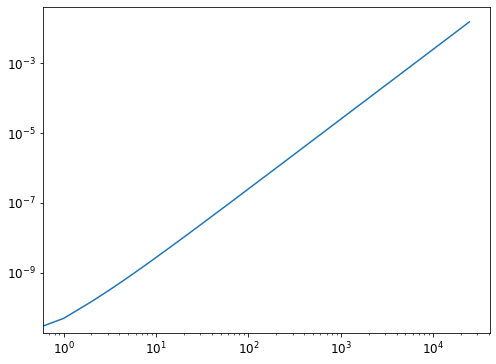

In [16]:
el = np.arange(lmax)
SN0 = SN * el*(el+1)/ (2 * np.pi) * 1e-4
plt.loglog(el,SN0)
plt.show()

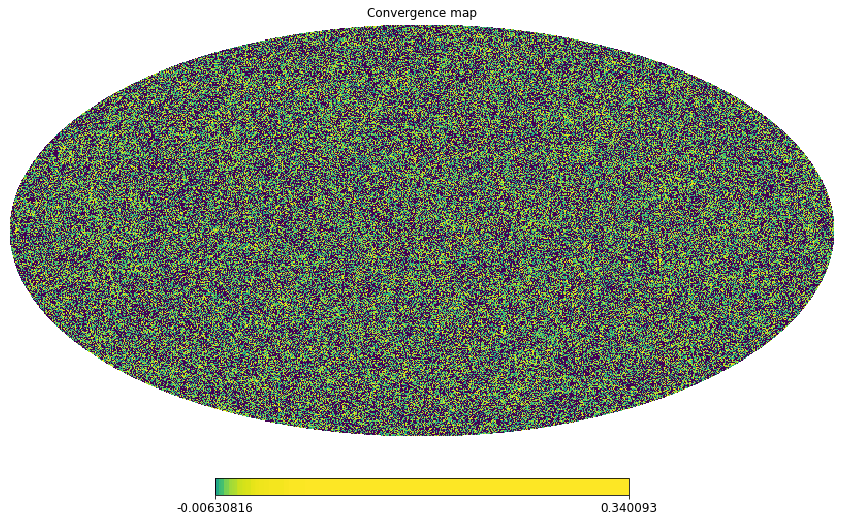

In [17]:
fig1 = plt.figure(figsize = (12,12))
hp.mollview(kappa_map, norm = 'hist', fig = fig1.number, title = 'Convergence map')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


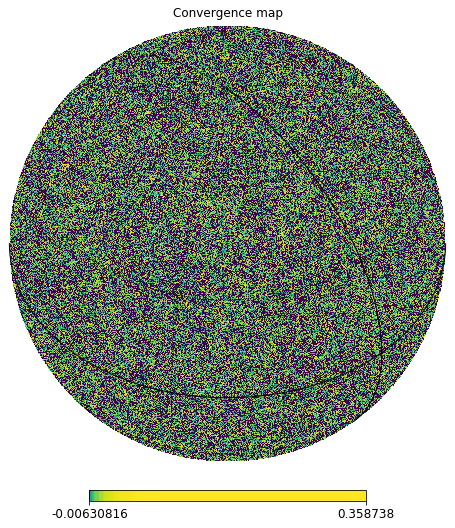

In [18]:
fig0 = plt.figure(figsize = (8,8))
hp.orthview(kappa_map, norm = 'hist', fig = fig0.number, title = 'Convergence map', half_sky = True, rot = (45,45,0))
hp.graticule()

In [19]:
n = 200
res = 1
x = np.arange(0, n)
y = np.arange(0, n)
xv, yv = np.meshgrid(x, y)

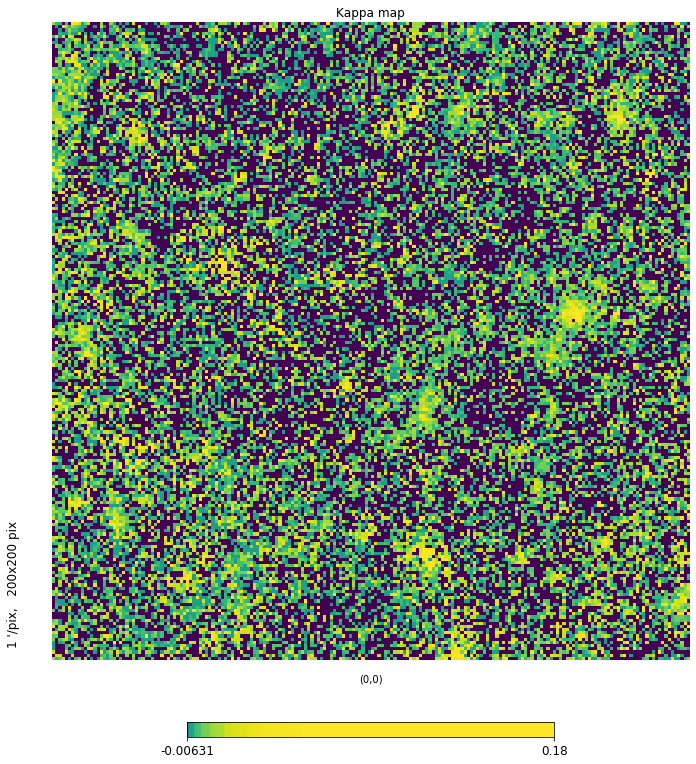

In [20]:
fig2 = plt.figure(figsize = (12,12))
k_map = hp.gnomview(kappa_map, fig = fig2.number, norm = 'hist', xsize = n, reso = res, return_projected_map = True, title = 'Kappa map')

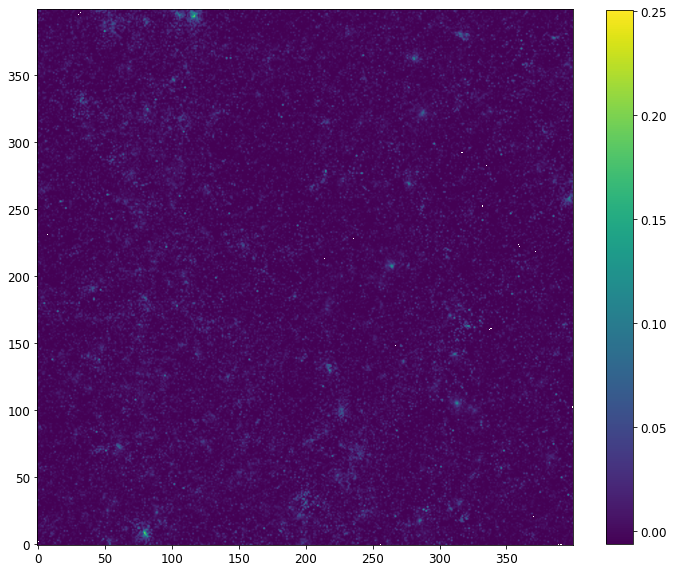

In [25]:
Cmap = cm.get_cmap('viridis')
Interp =  'gaussian'
g_min = k_map.min()
g_max = k_map.max()
#Norm = cm.colors.LogNorm(abs(g_min), g_max + abs(g_min))
Norm = cm.colors.Normalize(g_min, g_max)
fig3 = plt.figure(figsize = (12,12))
ax = fig3.gca()
img = ax.imshow(k_map,cmap = Cmap, norm = Norm, interpolation = Interp, origin='lower')
plt.colorbar(mappable = img,shrink = 0.82)
plt.show()

In [25]:
print('anafast started', datetime.now())
cl, alm = hp.anafast(kappa_map, alm = True)
ell = np.arange(len(cl))
print('anafast completed', datetime.now(),'number of l values = ', len(cl))

anafast started 2020-03-27 16:12:29.711307
anafast completed 2020-03-27 16:24:02.554985 number of l values =  24576


In [148]:
# Save Cls
outpath = '/cosma6/data/dp004/dc-boot5/Power Spectrum/Cl_Spectrum_Sussex/'
fname = outpath + 'Cl_nside_Sigma_{0:0d}'.format(nside)
hp.write_cl(fname, cl, dtype=np.float32,  overwrite = True)

In [26]:
# Read previously saved Cls and alms
outpath = '/cosma6/data/dp004/dc-boot5/Power Spectrum/Cl_Spectrum_Sussex/'
fname = outpath + 'Cl_nside_Sigma_{0:0d}'.format(nside)
cl = hp.read_cl(fname)
fname = outpath + 'Alm_nside_Sigma_{0:0d}'.format(nside)
alm = hp.read_alm(fname)
ell = np.arange(len(cl))

/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/fitsfunc.py:622: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.real[i] = almr
/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/fitsfunc.py:623: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.imag[i] = almi


In [31]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

In [32]:
lmax = len(cl)
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=o_b, omch2=o_c)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
#Set up W(z) window function
pars.SourceWindows = [GaussianSourceWindow(redshift=0.287, source_type='lensing', sigma=0.05)]
results = camb.get_results(pars)
cls = results.get_source_cls_dict()

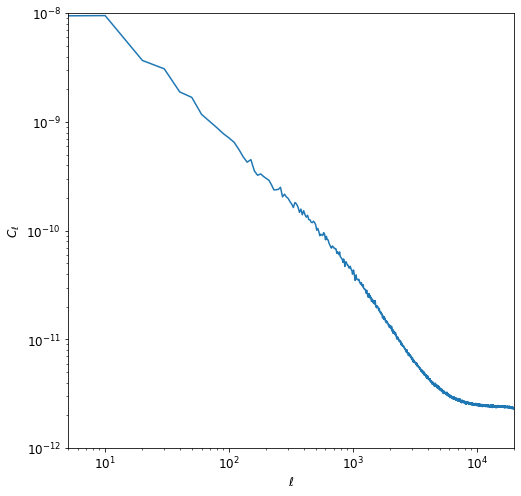

In [27]:
plt.figure(figsize = (8,8))
plt.loglog(ell[::10],cl[::10])
plt.xlabel('$\ell$', size = 'large')
plt.ylabel('$C_{\ell}$', size = 'large')
plt.xlim(5, 2e4)
plt.ylim(1e-12,1e-8)
plt.show()

In [28]:
cl1 = cl * (ell*(1+ell))/(2*np.pi)

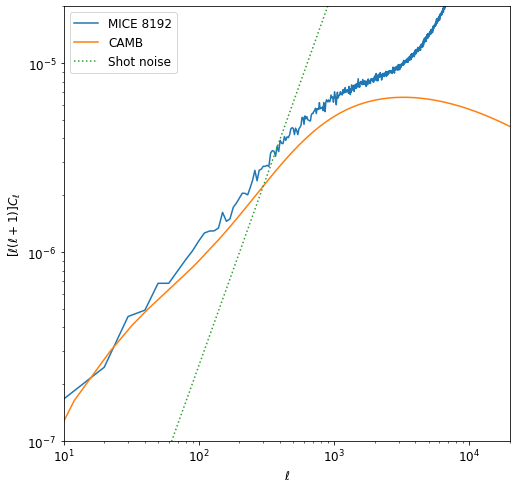

In [33]:
fig = plt.figure(figsize = (8,8))
plt.loglog(ell[::10],cl1[::10], label = 'MICE 8192')
#plt.loglog(ell[:l2:100],cl2[::100], label = 'MICE 4096')
#plt.loglog(ell[::10],cl2[::10], label = 'MICE 2048')
#plt.loglog(ell[::10],cl3[::10], label = 'MICE 1024')
plt.loglog(ell[2:lmax:10], cls['W1xW1'][2:lmax:10], label='CAMB')
plt.loglog(el,SN0, linestyle = ':', label = 'Shot noise')
plt.xlabel('$\ell$', size = 'large')
plt.ylabel('$[\ell(\ell+1)]C_{\ell}$', size = 'large')
plt.xlim(1e1, 2e4)
plt.ylim(1e-7,2e-5)
plt.legend()
plt.show()

In [446]:
N=8
for lp in range(N):
    d =(lp+1)*depth
     # Calculate redshift for this lens
    z = z_at_value(cosmo.comoving_distance,d/h*unit.Mpc)
    print(d, z)  

100 0.03368687521415253
200 0.06792715655222271
300 0.10275811645837395
400 0.13821891861829583
500 0.17435072518809946
600 0.21119682922020816
700 0.24880276766753262
800 0.28721645221726316


In [34]:
# multiply a_lm by -1/(l(l+1)) to calculate psi_lm
# ref: https://github.com/healpy/healpy/blob/master/healpy/src/_sphtools.pyx
lmax = hp.Alm.getlmax(alm.size)
l,m = hp.Alm.getlm(lmax)
l = l[1::]    
alm[0]=0
alm[1::] *= -1/(l*(l+1))

In [35]:
# transform back to physical space
psi, d_theta, d_phi = hp.alm2map_der1(alm,nside)

In [36]:
# calculate gamma from theta and phi
gamma_t = np.sqrt(d_theta*d_theta + d_phi*d_phi)

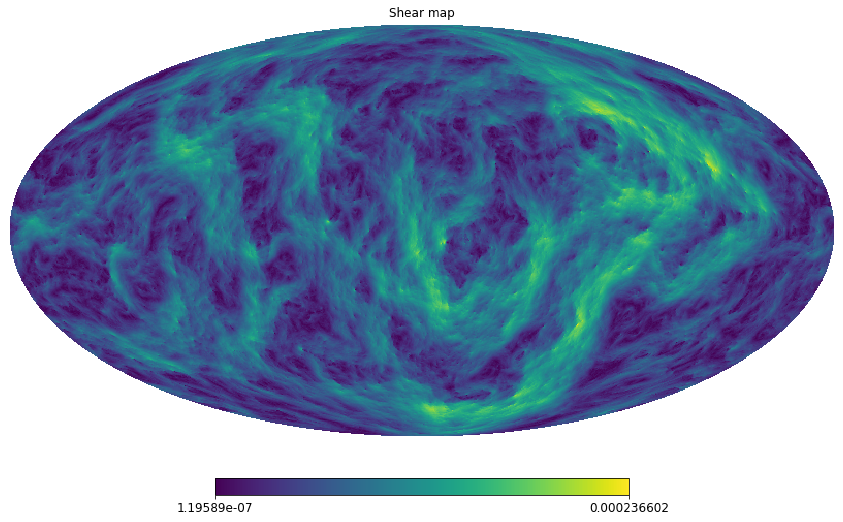

In [39]:
fig1 = plt.figure(figsize = (12,12))
hp.mollview(gamma_t, norm = 'None', fig = fig1.number, title = 'Shear map')
#plt.savefig('Convergence map, nside={0:0d}'.format(nside))

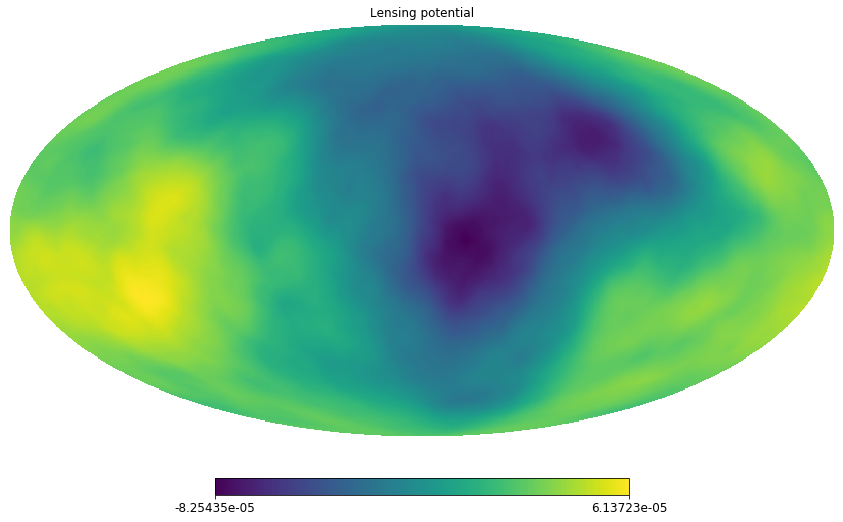

In [40]:
fig1 = plt.figure(figsize = (12,12))
hp.mollview(psi, norm = 'None', fig = fig1.number, title = 'Lensing potential')

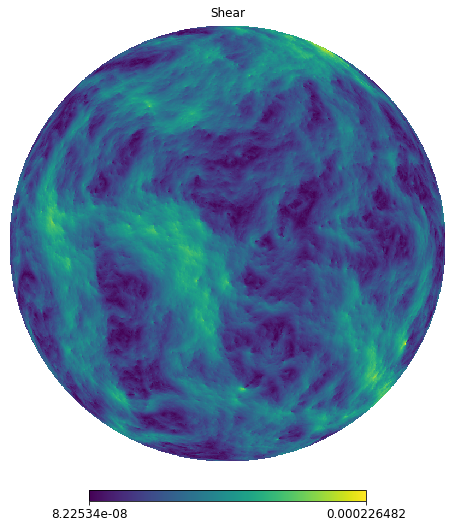

In [41]:
fig2 = plt.figure(figsize = (8,8))
hp.orthview(gamma_t, norm = 'None', fig = fig2.number, title = 'Shear', half_sky = True, rot = (45,45,0))

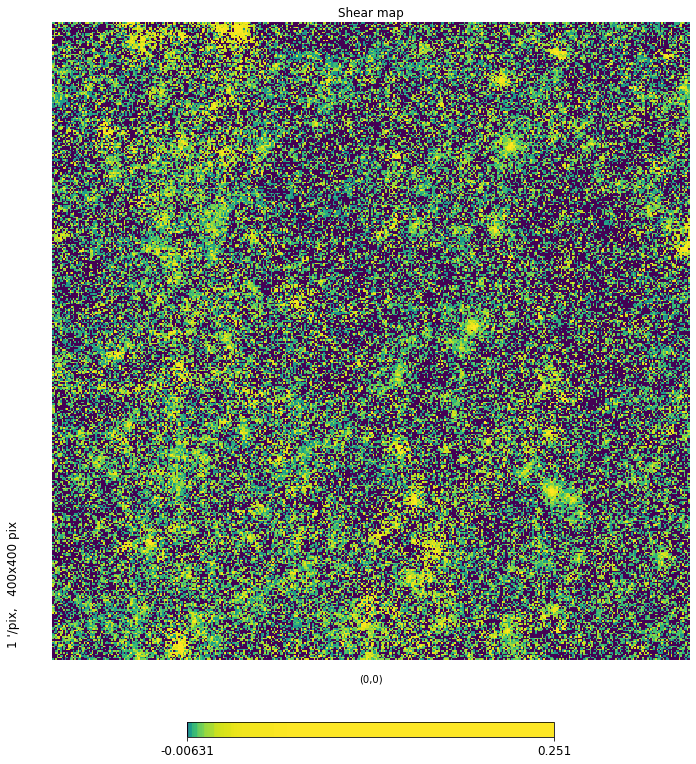

In [42]:
n = 400
res = 1
fig3 = plt.figure(figsize = (12,12))
k_map = hp.gnomview(kappa_map, fig = fig3.number, norm = 'hist', xsize = n, reso = res, return_projected_map = True, title = 'Shear map')
plt.show()

In [43]:
n = 50
res = 120
x = np.arange(0, n)
y = np.arange(0, n)
xv, yv = np.meshgrid(x, y)

In [44]:
proj = hp.projector.GnomonicProj(xsize = n, reso = res)
kap_map = proj.projmap(kappa_map, vec2pix_func=partial(hp.vec2pix, nside))
u = proj.projmap(d_theta, vec2pix_func=partial(hp.vec2pix, nside))
v = -proj.projmap(d_phi, vec2pix_func=partial(hp.vec2pix, nside))

In [45]:
cdict = {'red':   [[0.00, 0.0, 0.0],
                   [0.50, 0.0, 0.0],
                   [0.80, 0.7, 0.7],
                   [1.00, 1.0, 1.0]],
         'green': [[0.00, 0.0, 0.0],
                   [0.10, 0.1, 0.1],
                   [0.40, 1.0, 1.0],
                   [0.80, 0.8, 0.8],
                   [1.00, 1.0, 1.0]],
         'blue':  [[0.00, 0.2, 0.2],
                   [0.30, 0.8, 0.8],
                   [0.80, 0.1, 0.1],
                   [1.00, 1.0, 1.0]]}

cmap_name = 'blue2'
newcmp = LinearSegmentedColormap(cmap_name, segmentdata=cdict, N=256)

In [48]:
cdict = {'red':   [[0.00, 0.0, 0.0],
                   [0.34, 0.0, 0.0],
                   [0.50, 1.0, 1.0],
                   [1.00, 1.0, 1.0]],
         'green': [[0.00, 0.0, 0.0],
                   [0.34, 0.86, 0.86],
                   [0.50, 0.92, 0.92],
                   [1.00, 0.0, 0.0]],
         'blue':  [[0.00, 1.0, 1.0],
                   [0.34, 1.0, 1.0],
                   [0.66, 0.0, 0.0],
                   [1.00, 0.0, 0.0]]}

cmap_name = 'Planck'
newcmp1 = LinearSegmentedColormap(cmap_name, segmentdata=cdict, N=256)

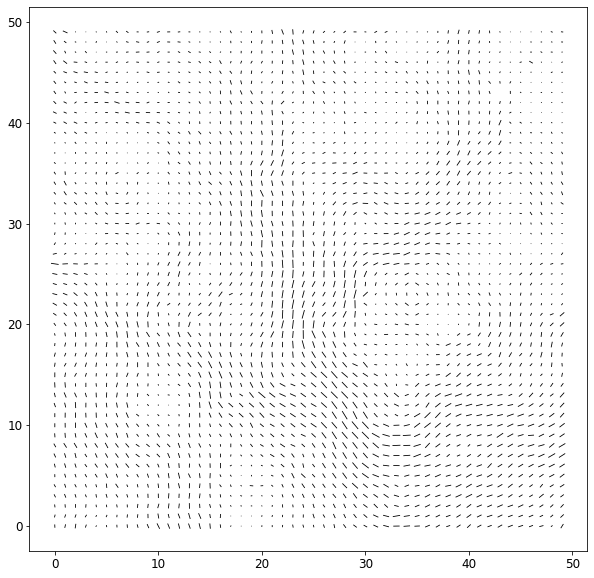

In [47]:
fig5 = plt.figure(figsize = (10,10))
ax = fig5.gca()
qiv  = ax.quiver(xv,yv,u,v, pivot ='mid', scale= 0.01, width = 0.0015, headlength=0, headwidth=0, headaxislength=0)
plt.show()

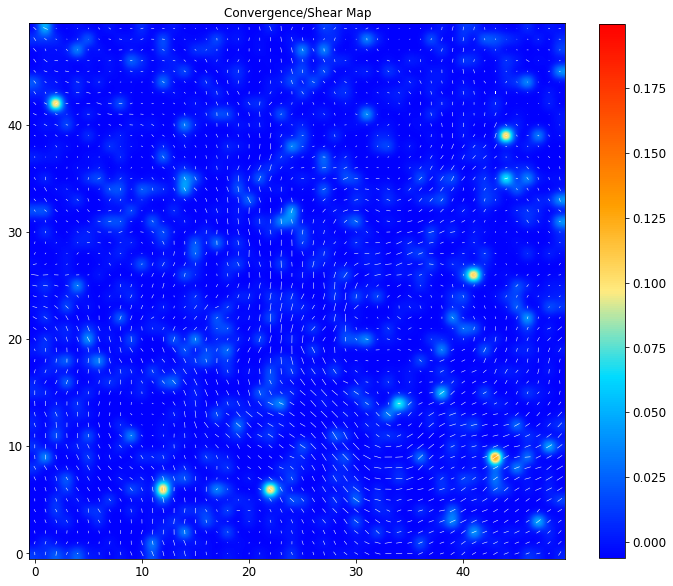

In [52]:
Cmap = cm.get_cmap('viridis')
Cmap = newcmp1
Interp = 'gaussian' #'bicubic'
g_min = kap_map.min()
g_max = kap_map.max()
#Norm = cm.colors.LogNorm(abs(g_min), g_max + abs(g_min))
Norm = cm.colors.Normalize(kap_map.min(), kap_map.max())
fig4 = plt.figure(figsize = (12,12))
ax = fig4.gca()
img = ax.imshow(kap_map,cmap = Cmap, norm = Norm, interpolation = Interp, origin='lower')
qiv  = ax.quiver(xv,yv,u,v, pivot ='mid', scale= 0.01, width = 0.001, headlength=0, headwidth=0, headaxislength=0, color = 'w')
plt.colorbar(mappable = img,shrink = 0.82)
plt.title('Convergence/Shear Map')
plt.savefig('Shear plot: nside = {0:0d}, pixels = {1:0d}, res = {2:0.0f}'.format(nside,n, res))
plt.show()

In [101]:
print('anafast started', datetime.now())
cl = hp.anafast(gamma_t, alm = False)
ell = np.arange(len(cl))
print('anafast completed', datetime.now(),'number of l values = ', len(cl))

anafast started 2020-03-19 20:25:02.584262
anafast completed 2020-03-19 20:36:14.608398 number of l values =  24576


In [146]:
cl4 = cl * (ell*(1+ell))**2/(2*np.pi) * 2

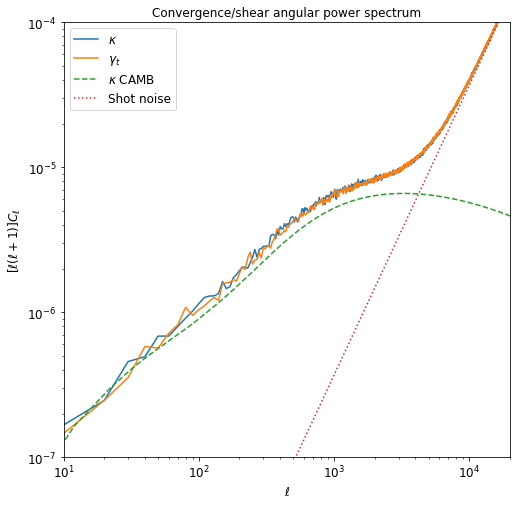

In [147]:
fig6 = plt.figure(figsize=(8,8))
plt.loglog(ell[::10],cl1[::10], label = '$\kappa$')
plt.loglog(ell[::10],cl4[::10], label = '$\gamma_t$')
plt.loglog(ell[2:lmax:10], cls['W1xW1'][2:lmax:10], linestyle = '--', label='$\kappa~$CAMB')
plt.loglog(el,SN0* 1.5e-2, linestyle = ':', label = 'Shot noise')
plt.xlim(1e1,2e4)
plt.ylim(1e-7, 1e-4)
plt.title('Convergence/shear angular power spectrum')
plt.ylabel('$[\ell(\ell+1)]C_{\ell}$')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

In [100]:
d_theta.sum()

9449.171063878046